In [1]:
import os
import re
import string
import zipfile
import numpy as np
from os import path
from collections import Counter
from urllib.request import urlretrieve
import sklearn
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter
import unidecode
EPSILON = 1e-15

### I - Loading and visualizing pre-trained embeddings

Two 100 dimensional pre-trained word embeddings are available here:
- GloVe
- Word2vec

To measure similarity between vectors, we often use the cosine similarity.
(https://en.wikipedia.org/wiki/Cosine_similarity)
$cosine\_similarity(w_1, w_2) = \Large \frac{\langle w_1, w_2 \rangle}{||w_1|| \cdot ||w_2||} = \frac{w_1^T \cdot w_2}{||w_1|| \cdot ||w_2||}$

$w_1$ and $w_2$ are two word vector embeddings.

It is a measure of how aligned $w_1$ and $w_2$ are.

In [2]:
class PretrainedEmbeddings():
    def __init__(self, language, embeddings):
        self.vec_file = None
        if language == 'en':
            if embeddings == 'glove':
                self.vec_file = 'glove_100k.en.vec.zip'
            elif embeddings == 'w2v':
                self.vec_file = 'w2v_1600k.en.vec.zip'
        elif language == 'fr':
            if embeddings == 'glove':
                print('No GloVe french embeddings!')
                return None
            elif embeddings == 'w2v':
                self.vec_file = 'w2v_800k.fr.vec.zip'
        self.language = language
        self.url = "https://github.com/ECE-Deep-Learning/courses_labs/releases/download/0.1/" + self.vec_file
        self.file_location_compressed = os.path.join('data', self.vec_file)
        self.file_location = self.file_location_compressed.replace('.zip', '')
        self.embeddings_index = None
        self.embeddings_index_inversed = None
        self.embeddings_vectors = None
        self.voc_size = None
        self.dim = None
    
    @staticmethod
    def _normalize(array):
        return array / np.linalg.norm(array, axis=-1, keepdims=True)
        
    def download_and_extract(self):
        if not path.exists(self.file_location):
            print('Downloading from %s to %s...' % (self.url, self.file_location_compressed))
            print(self.url)
            urlretrieve(self.url, self.file_location_compressed)
            print('Downloaded embeddings')
            print('Extracting from %s to %s...' % (self.file_location_compressed, self.file_location))
            with zipfile.ZipFile(self.file_location_compressed, 'r') as zip_ref:
                zip_ref.extractall('data')
            os.remove(self.file_location_compressed)
    
    """
    Note that you can choose to normalize directly the embeddings 
    to make the cosine similarity computation easier afterward.
    """
    def load(self, normalize=False):
        self.embeddings_index, self.embeddings_index_inversed = {}, {}
        self.embeddings_vectors = []
        file = open(self.file_location)
        header = next(file)
        self.voc_size, self.dim = [int(token) for token in header.split()]
        print('Vocabulary size: {0}\nEmbeddings dimension: {1}'.format(self.voc_size, self.dim))
        print('Loading embeddings in memory...')
        for idx, line in enumerate(file):
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            self.embeddings_index[word] = idx
            self.embeddings_index_inversed[idx] = word
            self.embeddings_vectors.append(vector)
        self.embeddings_vectors = np.asarray(self.embeddings_vectors)
        print('Embeddings loaded')
        if normalize:
            self.embeddings_vectors = self._normalize(self.embeddings_vectors)
            print('Embeddings normalized')
        file.close()
    
    """ 
    Return an embedding vector associated to a given word.
    For this you are supposed to used the objects defined in the load function.
    Be sure to handle the case where the received word is not found in the embeddings' vocabulary.
    """
    def word_to_vec(self, word):
        idx = self.embeddings_index.get(word)
        return self.embeddings_vectors[idx] if idx is not None else None
    
    """
    Return the closest word associated to a given embedding vector
    The vector passed as argument might not be in self.embeddings_vectors
    In other terms, you have to compute every cosine similarity between the vec argument
    and the embeddings found in self.embeddings_vectors. Then determine the embedding in 
    self.embeddings_vectors with the highest similarity and return its associated string word
    """
    def vec_to_closest_word(self, vec):
        cosines = np.dot(self.embeddings_vectors, self._normalize(vec))
        most_similar_index = np.argsort(cosines)[::-1][0]
        return self.embeddings_index_inversed[most_similar_index]
    
    """
    Return the n top similar words from a given string input.
    The similarities are based on the cosine similarities between the embeddings vectors.
    Note that the string could be a full sentence composed of several words.
    Split the sentence, map the words that can be found in self.embeddings_vectors to vectors and
    average them. 
    Then return the top (default: top=10) words associated to the top embeddings
    in self.embeddings_vectors that have the highest cosine similarity with the previously computed average.
    """
    def most_similar(self, query, top=10):
        query = str(query).split()
        query_vec = np.zeros(self.dim)
        for token in query:
            token_vec = self.word_to_vec(token)
            if token_vec is not None:
                query_vec += token_vec
        if np.all(query_vec == 0):
            print('No existing words found!')
            return None
        cosines = np.dot(self.embeddings_vectors, self._normalize(query_vec))
        most_similar_indexes = np.argsort(cosines)[::-1][:top]
        return [(self.embeddings_index_inversed[idx], cosines[idx]) 
                for idx in most_similar_indexes]
    
    def project_and_visualize(self, sample=1000):
        embeddings_tsne = TSNE(perplexity=30).fit_transform(self.embeddings_vectors[:sample])
        plt.figure(figsize=(40, 40))
        axis = plt.gca()
        np.set_printoptions(suppress=True)
        plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], marker=".", s=1e-6)
        for idx in range(sample):
            plt.annotate(
                self.embeddings_index_inversed[idx],
                xy=(embeddings_tsne[idx, 0], embeddings_tsne[idx, 1]),
                xytext=(0, 0), textcoords='offset points'
            )

In [10]:
pretrained_embeddings = PretrainedEmbeddings(language='en', embeddings='glove')
pretrained_embeddings.download_and_extract()
pretrained_embeddings.load(normalize=True)

Vocabulary size: 100000
Embeddings dimension: 100
Loading embeddings in memory...
Embeddings loaded
Embeddings normalized


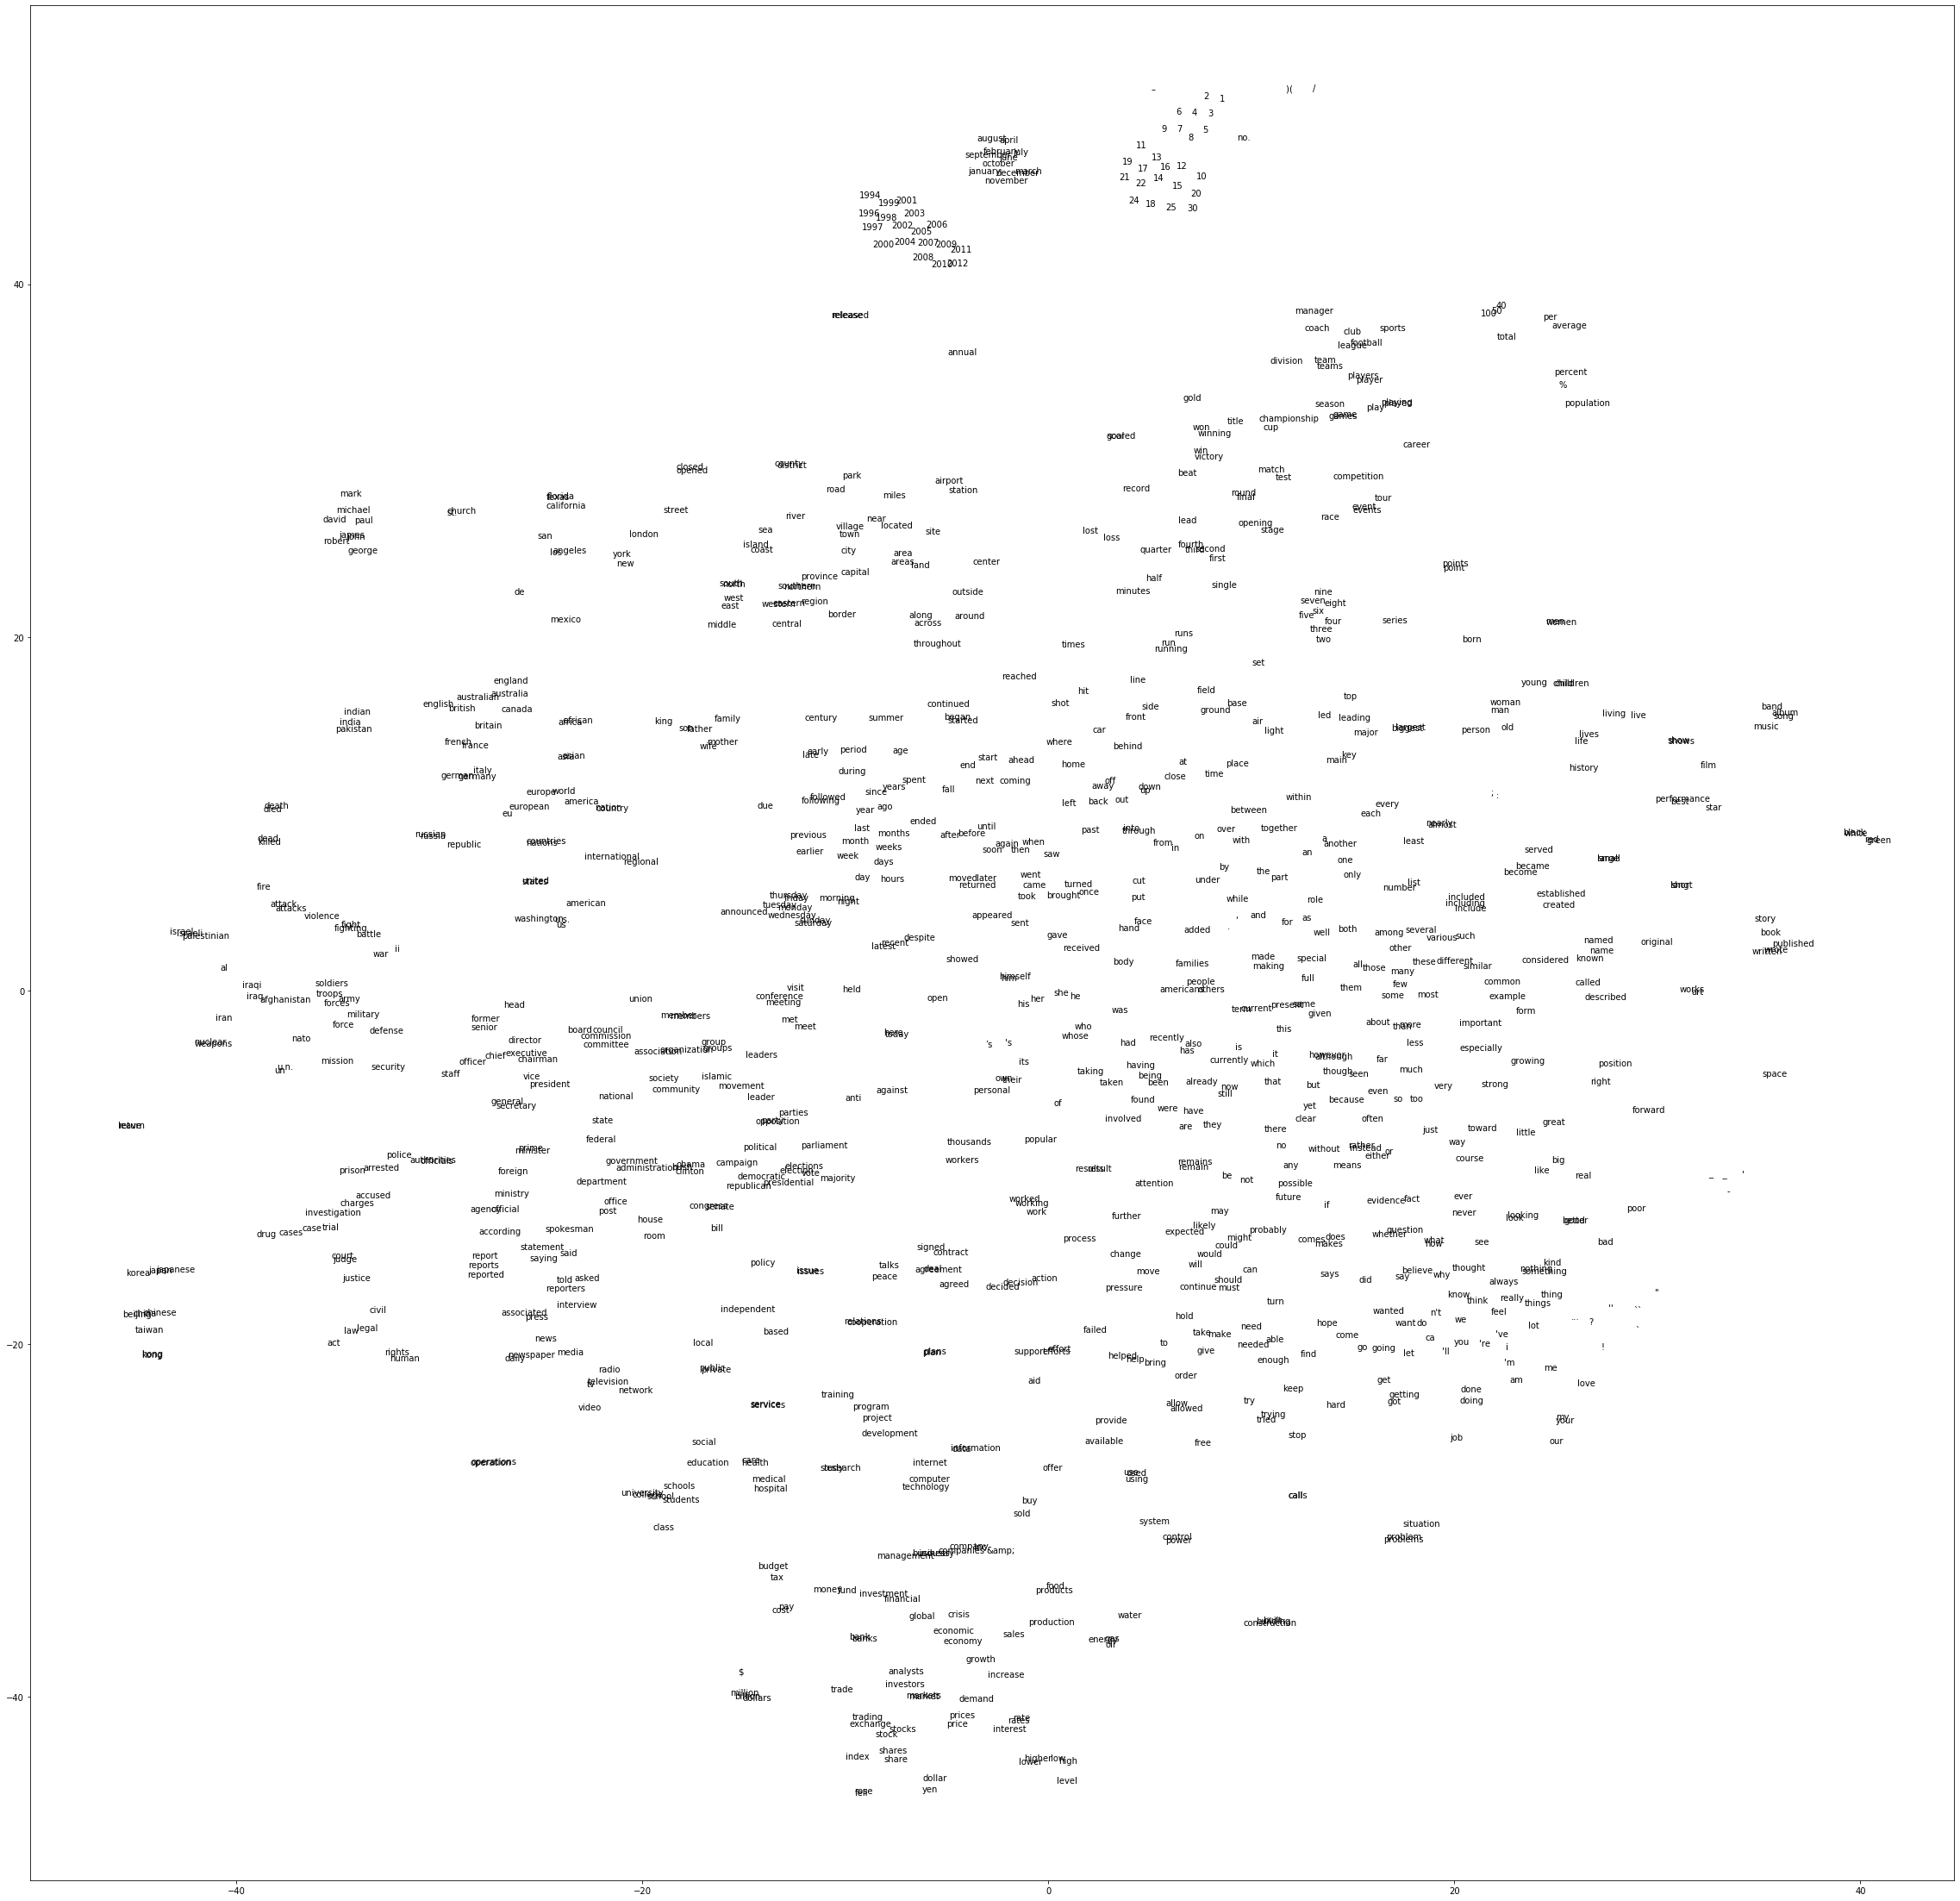

In [4]:
pretrained_embeddings.project_and_visualize()

In [5]:
pretrained_embeddings.vec_to_closest_word(pretrained_embeddings.word_to_vec('language'))

'language'

In [6]:
pretrained_embeddings.most_similar('beef and chicken')

[('beef', 0.8599827499883292),
 ('chicken', 0.8550986024720875),
 ('meat', 0.840467097369632),
 ('pork', 0.7974475701129562),
 ('food', 0.7118758270980263),
 ('lamb', 0.69351775557125),
 ('vegetables', 0.6878796295412097),
 ('fish', 0.6773438490369881),
 ('poultry', 0.6758433527151971),
 ('milk', 0.6662893146057255)]

## Questions:

#### • Observe the visualization plot. <br> &rarr; What can you say about very common words? <br> &rarr; Are you able to identify some clusters catching a specific semantical concept?

#### • What may be happen if you try to call the "most similar" method with a very long sentence? Will it be accurate? Why?

### II - Language modelling

#### Sampling random text from the model

First part of language modelling will be about predicting the next character of a finite sequence of characters of size $k$.

Recursively generate one character at a time: your model outputs the probability distribution $p_{\theta}(c_{n} | c_{n-1}, \ldots, c_{n-k})$

Using this probability distribution, a predicted character $c_{n}$ will be sampled. The temperature parameter makes it possible to remove additional entropy (bias) into the parameterized multinoulli distribution of the output of the model.

Then use your prediction $c_{n}$ to compute $c_{n+1}$, your model outputs: $p_{\theta}(c_{n+1} | c_{n}, \ldots, c_{n-k+1})$, and so on

In [3]:
class LanguageModel():
    def __init__(self):
        self.corpus_path = None
        self.corpus = None
        
    def _get_contiguous_sample(self, corpus, size):
        print(len(corpus), size)
        index = np.random.randint(0, len(corpus) - size + 1)
        return corpus[index:index+size]
    
    def load_data(self, corpus_path, proportion_to_keep=1):
        assert 0 <= proportion_to_keep <= 1, "proportion_to_keep should be between 0 and 1"
        self.corpus_path = os.path.join('data', corpus_path)
        file = open(self.corpus_path)
        entire_corpus = file.read()
        self.corpus = unidecode.unidecode(
            self._get_contiguous_sample(
                entire_corpus, size=int(proportion_to_keep*len(entire_corpus))
            ).lower().replace("\n", " ")
        )
        print('Corpus length: {0} characters'.format(len(self.corpus)))
        file.close()
        
    def plot_vocabulary_distribution(self):
        counter = Counter(self.corpus)
        chars, counts = zip(*counter.most_common())
        indices = np.arange(len(counts))
        plt.figure(figsize=(16, 5))
        plt.bar(indices, counts, 0.8)
        plt.xticks(indices, chars)

In [8]:
sample_size = 500

language_model = LanguageModel()
language_model.load_data('lambada_cleaned_sample.txt', proportion_to_keep=1e-4)
print('Loaded sample:\n{0}'.format(language_model.corpus))

10000000 1000
Corpus length: 1000 characters
Loaded sample:
e past and knew he could count on him when needed, but tarrek was new to the group and still an unknown quantity. with a basic plan already formed, without a doubt a third person was required to pull it off. the rest of the plan would require a great deal of luck and a bit of flexibility as it developed. phaelon and mordan had been in the employ of lord damon for many cycles handling his dirty work, but nothing up until this point was as risky as what they were currently faced with, after all, damon was requesting that phaelon and his team abduct the son of the king of all arcadians and end his days, but the difficulty came in the form of making it appear as though an accident had befallen the prince who was always accompanied by three guardians. therein lay the difficulty. at first phaelon considered declining lord damon's request, but the rewards offered were too great and could n't be ignored. beyond that, turning down lord

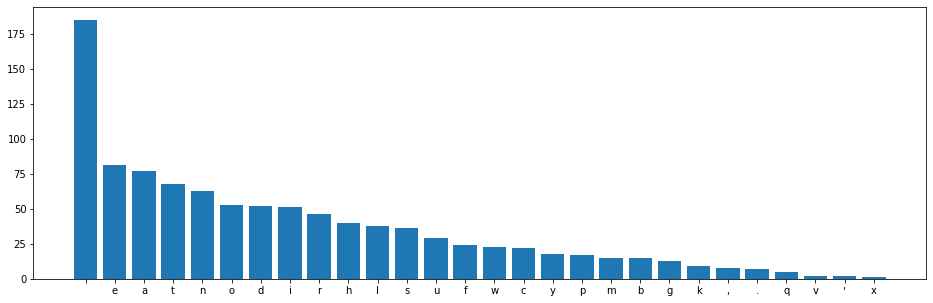

In [9]:
language_model.plot_vocabulary_distribution()

### II - a) Character-based language modelling

#### Measuring per-character perplexity

To measure the quality of a language model we usually use the perplexity.
(https://en.wikipedia.org/wiki/Perplexity)

Here is how it is defined:

$$perplexity_\theta = 2^{-\frac{1}{n} \sum_{i=1}^{n} log_2 (p_\theta(c_i)^T\cdot y_i)}$$
$p_\theta(c_i)$ is your predicted column vector of probabilities over the possible next characters for the $i^{th}$ sequence.
$y_i$ is the one-hot encoding vector of the answer: the next character of the $i^{th}$ sequence.

You just compute the average negative loglikelihood like you have done previously, only using a log2 logarithm. Then just perform a base $2$ exponentiation of the quantity just computed.

In [4]:
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical

In [11]:
"""
Character based langage model implementation
corpus_path: path of the corpus to load
proportion_to_keep: contiguous proportion of the corpus that will be stored in memory
hidden_size: hidden layer dimension
char_embedding: if set to True, a dense embedding layer will be trained
embedding_size: embedding layer dimension if char_embedding is True
model: pre-trained model to use
"""

class CharLanguageModel(LanguageModel):
    def __init__(self, corpus_path, proportion_to_keep=1,
                 hidden_size=256, char_embedding=False, embedding_size=32, model=None):
        super(LanguageModel, self).__init__()
        self.char_index = None
        self.char_index_inversed = None
        self.vocabulary_size = None
        self.max_length_sequence = None
        self.X = None
        self.y = None
        self.hidden_size = hidden_size
        self.char_embedding = char_embedding
        self.embedding_size = embedding_size
        self.load_data(corpus_path, proportion_to_keep)
        self.extract_vocabulary()
        self.build_dataset()
        self.model = self._get_model() if model is None else model
        
    """
    Define and compile a Keras model, it will deal with sequences of length max_length_sequence
    The representation size depends on the tokens' representation you chose
    It should be composed of :
        - an optional Embedding layer projecting into embedding_size dimensions: it will learn a distributed
        representation of the given vocabulary
        - one recurrent LSTM layer projecting into hidden_size dimensions
        - one Dense layer with a softmax activation projecting into vocabulary_size dimensions
    """
    def _get_model(self):
        representation_size = self.embedding_size if self.char_embedding else self.vocabulary_size
        model = Sequential()
        if self.char_embedding:
            model.add(
                Embedding(self.vocabulary_size, self.embedding_size, 
                          input_length=self.max_length_sequence)
            )
        model.add(
            LSTM(self.hidden_size, input_shape=(
                self.max_length_sequence, representation_size
            ))
        )
        model.add(
            Dense(self.vocabulary_size, activation='softmax')
        )
        optimizer = Adam()
        model.compile(
            optimizer=optimizer, 
            loss='categorical_crossentropy',
        )
        return model

    def extract_vocabulary(self):
        chars = sorted(set(self.corpus))
        self.char_index = dict((c, i) for i, c in enumerate(chars))
        self.char_index_inversed = dict((i, c) for i, c in enumerate(chars))
        self.vocabulary_size = len(self.char_index)
        print('Vocabulary size: {0}'.format(self.vocabulary_size))
        
    """
    Methods to convert X into an encoded matrix
    
    Importante note: if the sequence length if smaller than max_length_sequence, 
    we pad the input with zeros vectors at the beginning of the encoded matrix
    
    Hints:
      - You can use the sequence method from keras.preprocessing to pad the received sequences
      - You can use the to_categorical method from keras.utils with a specified num_classes parameters to 
        one-hot encode your data
    """
    def _integer_encoding(self, X):
        X_encoded = np.asarray([list(map(lambda x: self.char_index[x], X_i)) for X_i in X])
        return sequence.pad_sequences(X_encoded, maxlen=self.max_length_sequence)
    
    def _one_hot_encoding(self, X):
        return to_categorical(self._integer_encoding(X), num_classes=self.vocabulary_size)
    
    """
    The matrices X and y are created in this method
    It consists of sampling contiguous chunks in the corpus as training vectors with the next character as target
    Then, an encoding method is called depending on the tokens' representation you chose to use in your model
    """
    def build_dataset(self, min_length_sequence=5, max_length_sequence=30, step=10, trunc_freq=0.05):
        self.X, self.y = [], []

        for i in range(0, len(self.corpus)-max_length_sequence, step):
            length_sequence = max_length_sequence
            if np.random.rand() < trunc_freq:
                length_sequence = np.random.choice(range(min_length_sequence, max_length_sequence+1))
            self.X.append(self.corpus[i:i+length_sequence])
            y_one_hot = np.zeros(self.vocabulary_size)
            y_one_hot[self.char_index[self.corpus[i+length_sequence]]] = 1
            self.y.append(y_one_hot)

        self.X, self.y = np.asarray(self.X), np.asarray(self.y)

        self.max_length_sequence = max_length_sequence
        self.X, self.y = sklearn.utils.shuffle(self.X, self.y)
        print('Number of training sequences: {0}'.format(len(self.X)))
        if self.char_embedding:
            self.X = self._integer_encoding(self.X)
        else:
            self.X = self._one_hot_encoding(self.X)
        if self.X is not None and self.y is not None:
            print('X shape: {0}\ny shape: {1}'.format(self.X.shape, self.y.shape))

    """
    Actual model training, call the model's fit method
    """
    def train(self, batch_size=64, epochs=10):
        self.model.fit(
            self.X, self.y, validation_split=0.1, batch_size=batch_size, epochs=epochs
        )
    
    """
    Return the prediction of our model, meaning the next token given an input sequence
    
    If preprocessed is specified as True, we consider X as an array of strings and we will transform
    it to an encoded matrix
    Else, if preprocessed is specified as False, we apply the model predict on X as it is
    """
    def predict(self, X, verbose=1, preprocessed=True):
        if not preprocessed:
            X = self._integer_encoding(X) if self.char_embedding else self._one_hot_encoding(X)
        return self.model.predict(X, verbose=verbose)
    
    """
    Perplexity metric used to appreciate the performance of our model
    """
    def perplexity(self, y_true, y_pred):
        likelihoods = np.sum(y_pred * y_true, axis=1)
        return 2 ** -np.mean(np.log2(likelihoods + EPSILON))
    
    """
    Sample the next character according to the predictions.
    
    Use a lower temperature to force the model to output more
    confident predictions: more peaky distribution.
    """
    def _sample_next_char(self, preds, temperature=1.0):
        preds = np.asarray(preds).astype('float64')
        preds = np.log(preds + EPSILON) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds + EPSILON)
        probs = np.random.multinomial(1, preds, size=1)
        return np.argmax(probs)
    
    """
    Try to generate some text using the trained model and a given seed string as starting point
    The process is to sample the next char in our predicted tokens' distribution 
    until we reach the specified length
    """
    def generate_text(self, seed_string, length=300, temperature=1.0):
        if self.model is None:
            print('The language model has not been compiled yet!')
            return seed_string
        generated = seed_string
        prefix = seed_string
        for i in range(length):
            predictions = np.ravel(self.predict([prefix], verbose=0, preprocessed=False))
            next_index = self._sample_next_char(predictions, temperature)
            next_char = self.char_index_inversed[next_index]
            generated += next_char
            prefix = prefix[1:] + next_char
        return generated
    
    """
    Project and visualize our character embedding layer in 2D
    """
    def visualize_char_embeddings(self):
        if not self.char_embedding or self.model is None:
            print('No trained character embedding layer!')
            return None
        char_embeddings = self.model.get_weights()[0]
        embeddings_tsne = TSNE(perplexity=30).fit_transform(char_embeddings)
        plt.figure(figsize=(8, 8))
        axis = plt.gca()
        np.set_printoptions(suppress=True)
        plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], marker=".", s=1e-6)
        for idx in range(len(char_embeddings)):
            plt.annotate(
                self.char_index_inversed[idx],
                xy=(embeddings_tsne[idx, 0], embeddings_tsne[idx, 1]),
                xytext=(0, 0), textcoords='offset points'
            )

#### one-hot encoding

In [12]:
language_model = CharLanguageModel(
    corpus_path='lambada_cleaned_sample.txt', proportion_to_keep=0.2, char_embedding=False
)
language_model.model.summary()

10000000 2000000
Corpus length: 2000000 characters
Vocabulary size: 45
Number of training sequences: 199997
X shape: (199997, 30, 45)
y shape: (199997, 45)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               309248    
_________________________________________________________________
dense (Dense)                (None, 45)                11565     
Total params: 320,813
Trainable params: 320,813
Non-trainable params: 0
_________________________________________________________________


In [13]:
seed_string = "go on, surprise me, say something clever to "
epochs = 10
for epoch in range(epochs):
    language_model.train(epochs=1)
    if (epoch + 1) % 5 == 0:
        perplexity = language_model.perplexity(
            language_model.y, language_model.model.predict(language_model.X)
        )
        print('Perplexity after {} epochs: {}'.format(epoch + 1, perplexity))
        print(language_model.generate_text(seed_string, temperature=0.25))
        print(language_model.generate_text(seed_string, temperature=0.5))
        print(language_model.generate_text(seed_string, temperature=0.75))

Train on 179997 samples, validate on 20000 samples
179997/179997 [==============================] - 16s 90us/sample - loss: 2.2561 - val_loss: 1.9954
Train on 179997 samples, validate on 20000 samples
179997/179997 [==============================] - 13s 75us/sample - loss: 1.8846 - val_loss: 1.8098
Train on 179997 samples, validate on 20000 samples
179997/179997 [==============================] - 13s 75us/sample - loss: 1.7282 - val_loss: 1.7045
Train on 179997 samples, validate on 20000 samples
179997/179997 [==============================] - 14s 80us/sample - loss: 1.6161 - val_loss: 1.6339
Train on 179997 samples, validate on 20000 samples
179997/179997 [==============================] - 15s 82us/sample - loss: 1.5280 - val_loss: 1.5934
Perplexity after 5 epochs: 4.278924566193284
go on, surprise me, say something clever to her bect of the real of the corner and the strange and all the black and the black mistand the survival said. the stare of the liff could be the black of the sta

In [14]:
print(language_model.generate_text(seed_string, temperature=0.25) + '\n')
print(language_model.generate_text(seed_string, temperature=0.5) + '\n')
print(language_model.generate_text(seed_string, temperature=0.75) + '\n')

go on, surprise me, say something clever to him. he said. he was a ship on the stare and the outer strange as he stared at his offer and stared at him and stated the continue we are so going to be a most place. the crilshan could n't see the stare of the courted and still the secret past of her from a most slowly and the only the one ather of

go on, surprise me, say something clever to destro. i think her hands towerdrance it was us forward. anna scrains fact as she said. the transtill she asked like the broken from the only child, and the girnca metassed he stands and his wing, the sightate against the crew with the change of a setres of with the militant and continued to the old

go on, surprise me, say something clever to hurr you and needly and then were the entire of prottonar rending the remamb engier enturing his ficus ; the entapled so wo like silence. many we pursist the crowl of her and shading his hands by from out and said to reach at the birst. she said. you're something 

#### char embedding

In [15]:
language_model = CharLanguageModel(
    corpus_path='lambada_cleaned_sample.txt', proportion_to_keep=0.2, char_embedding=True
)
language_model.model.summary()

10000000 2000000
Corpus length: 2000000 characters
Vocabulary size: 44
Number of training sequences: 199997
X shape: (199997, 30)
y shape: (199997, 44)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 32)            1408      
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               295936    
_________________________________________________________________
dense_1 (Dense)              (None, 44)                11308     
Total params: 308,652
Trainable params: 308,652
Non-trainable params: 0
_________________________________________________________________


In [16]:
seed_string = "go on, surprise me, say something clever to "
epochs = 10
for epoch in range(epochs):
    language_model.train(epochs=1)
    if (epoch + 1) % 5 == 0:
        perplexity = language_model.perplexity(
            language_model.y, language_model.model.predict(language_model.X)
        )
        print('Perplexity after {} epochs: {}'.format(epoch + 1, perplexity))
        print(language_model.generate_text(seed_string, temperature=0.25))
        print(language_model.generate_text(seed_string, temperature=0.5))
        print(language_model.generate_text(seed_string, temperature=0.75))

Train on 179997 samples, validate on 20000 samples
179997/179997 [==============================] - 20s 108us/sample - loss: 2.1758 - val_loss: 1.8958
Train on 179997 samples, validate on 20000 samples
179997/179997 [==============================] - 17s 96us/sample - loss: 1.7770 - val_loss: 1.6880
Train on 179997 samples, validate on 20000 samples
179997/179997 [==============================] - 17s 92us/sample - loss: 1.6051 - val_loss: 1.5862
Train on 179997 samples, validate on 20000 samples
179997/179997 [==============================] - 17s 92us/sample - loss: 1.4945 - val_loss: 1.5143
Train on 179997 samples, validate on 20000 samples
179997/179997 [==============================] - 17s 96us/sample - loss: 1.4129 - val_loss: 1.4859
Perplexity after 5 epochs: 3.8500196521291348
go on, surprise me, say something clever to go to go the control of the control and proteus was strained on the control of the control and the control distantic strained and the walls and stood and he wa

In [17]:
print(language_model.generate_text(seed_string, temperature=0.25) + '\n')
print(language_model.generate_text(seed_string, temperature=0.5) + '\n')
print(language_model.generate_text(seed_string, temperature=0.75) + '\n')

go on, surprise me, say something clever to the black with a bad and stood and the man who had been the most believe the side of the ship, said the back of the passage of the system that seemed to look like the proteus were stopped in the ship, but he was n't to be a pin and the bottom of the ship of the hand of the same fingers were starting

go on, surprise me, say something clever to be sure to be continued to say a words in the real country the proteus what is growing a words in the sand of the shelf of the command was a pair remaining, a mind. raoden right a small dust to make the first have accomplam run to the cold like a long man with the said. it was a must have to be size

go on, surprise me, say something clever to contencial he would be. i took the words do n't have come becomering to come. i could keep it, reiding down his blanks of the balcory leaphty the silence of his clumb to remaise which was sat the suddenly radialy head break. my emerpout fassioned back to the profe

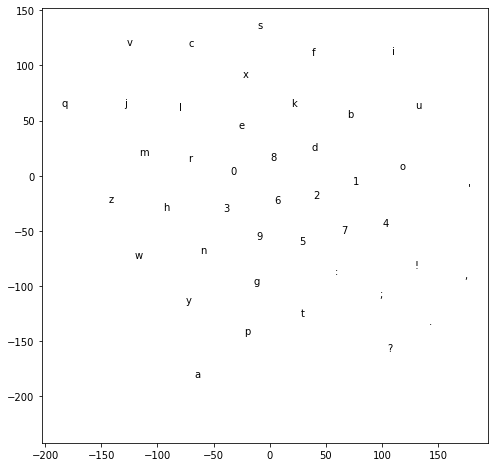

In [18]:
language_model.visualize_char_embeddings()

## Questions:

#### • With a high temperature, out of vocabulary words seem to happen more often. Can you briefly explain why it is the case?
#### • Adding an character embedding layer results to fewer trainable parameters in the end. <br> &rarr; Do the calculations and point out the main differences. <br> &rarr; Which one works better for text generation?

### II - b) Word-based language modelling

In [5]:
"""
Word based langage model implementation
corpus_path: path of the corpus to load
proportion_to_keep: contiguous proportion of the corpus that will be stored in memory
max_vocabulary: maximum number of different words to keep, other will be replaced with <OUT> token
hidden_size: hidden layer dimension
pretrained_embeddings: instance of PretrainedEmbeddings containing pre-trained word embeddings
embedding_size: embedding layer dimension, set to pretrained_embeddings.dim if pretrained_embeddings is specified
model: pre-trained model to use
"""

class WordLanguageModel(LanguageModel):
    def __init__(self, corpus_path, proportion_to_keep=1, max_vocabulary=1000,
                 hidden_size=256, pretrained_embeddings=None, embedding_size=100,
                 model=None):
        super(LanguageModel, self).__init__()
        self.word_index = None
        self.word_index_inversed = None
        self.vocabulary_size = None
        self.max_length_sequence = None
        self.X = None
        self.y = None
        self.max_vocabulary = max_vocabulary
        self.hidden_size = hidden_size
        if pretrained_embeddings is not None:
            if not isinstance(pretrained_embeddings, PretrainedEmbeddings):
                print('pretrained_embeddings should be an instance of PretrainedEmbeddings class')
                pretrained_embeddings = None
        self.pretrained_embeddings = pretrained_embeddings
        self.embedding_size = embedding_size if pretrained_embeddings is None else pretrained_embeddings.dim
        self.load_data(corpus_path, proportion_to_keep)
        self.punctuation_marks = None
        self.punctuation_marks_inversed = None
        self.corpus = self._tokenize(self.corpus)
        self.allowed_words = None
        self.corpus = self._limit_vocabulary(self.corpus)
        self.extract_vocabulary()
        self.build_dataset()
        self.model = self._get_model() if model is None else model
        if self.pretrained_embeddings is not None:
            self._initialize_pretrained_embeddings()
    
    """
    Being a word based LM, we have to tokenize our corpus and 
    replace unremoved punctuation marks by specific tokens
    """
    def _tokenize(self, corpus):
        self.punctuation_marks = {
            '.': ' <PERIOD> ',
            ',': ' <COMMA> ',
            '\'': ' <QUOTE> ',
            '?': ' <QUESTION> ',
            '!': ' <EXCLAMATION> ',
            ';': ' <SEMICOLON> ',
            ':': ' <COLON> ',
            '_': ' <UNDERSCORE> '
        }
        self.punctuation_marks_inversed = {v.strip(): k for k, v in self.punctuation_marks.items()}
        for punctuation_mark, token in self.punctuation_marks.items():
            corpus = corpus.replace(punctuation_mark, token)
        return corpus.split()
    
    """
    To avoid out of memory issues, we can limit our corpus to have a vocabulary 
    with a maximum number of different words
    Out of vocabulary words will be replaced by the <OUT> token
    During the inference, we'll use the existing counter
    """
    def _limit_vocabulary(self, corpus, use_existing_counter=False):
        if not use_existing_counter:
            counter = Counter(corpus)
            self.allowed_words = set([item[0] for item in counter.most_common(self.max_vocabulary)])
        return [word if word in self.allowed_words else '<OUT>' for word in corpus]
    
    """
    Define and compile a Keras model, it will deal with sequences of length max_length_sequence
    It should be composed of :
        - an Embedding layer projecting into embedding_size dimensions: it will learn a distributed
        representation of the given vocabulary
        - one recurrent LSTM layer projecting into hidden_size dimensions
        - one Dense layer with a softmax activation projecting into vocabulary_size dimensions
    """
    def _get_model(self):
        model = Sequential()
        model.add(
            Embedding(self.vocabulary_size, self.embedding_size, 
                      input_length=self.max_length_sequence)
        )
        model.add(
            LSTM(self.hidden_size, input_shape=(
                self.max_length_sequence, self.embedding_size
            ))
        )
        model.add(
            Dense(self.vocabulary_size, activation='softmax')
        )
        optimizer = Adam()
        model.compile(
            optimizer=optimizer, 
            loss='categorical_crossentropy',
        )
        return model
    
    """
    If a pretrained embeddings object is given, we overwrite the embedding weights matrix
    by the received pretrained embeddings
    
    Importante note: all the words in the corpus probably do not exist in the pretrained embeddings object 
    (at least punctuation tokens we just replaced earlier). 
    To solve this, we have to construct a map of indexes from one matrix to another, 
    and overwrite only rows containing words that are existing in both
    
    Hints: 
    you can retrieve the weights of a layer using its get_weights method, and update them as a numpy matrix
    then, you can plug them back in the layer using its set_weights method
    """
    def _initialize_pretrained_embeddings(self):
        index_to_pretrained_embeddings = {
            index: self.pretrained_embeddings.embeddings_vectors[self.pretrained_embeddings.embeddings_index[word]] 
            for word, index in self.word_index.items()
            if word in self.pretrained_embeddings.embeddings_index_inversed.values()
        }
        embeddings_weights = self.model.layers[0].get_weights()
        embeddings_weights[0][list(index_to_pretrained_embeddings.keys())] = \
            np.asarray(list(index_to_pretrained_embeddings.values()))
        self.model.layers[0].set_weights(embeddings_weights)

    def extract_vocabulary(self):
        words = sorted(set(self.corpus))
        self.word_index = dict((c, i) for i, c in enumerate(words))
        self.word_index_inversed = dict((i, c) for i, c in enumerate(words))
        self.vocabulary_size = len(self.word_index)
        print('Vocabulary size: {0}'.format(self.vocabulary_size))
    
    """
    Methods to convert X into an integer-encoded matrix
    
    One-hot encoding is discouraged in word-based language models: it would probably result to out of memory 
    issues due to a very large vocabulary size. Consequently, an embedding layer is mandatory
    
    Importante note: if the sequence length if smaller than max_length_sequence, 
    we pad the input with zeros vectors at the beginning of the encoded matrix
    
    Hints:
      - You can use the sequence method from keras.preprocessing to pad the received sequences
    """
    def _integer_encoding(self, X):
        X_encoded = np.asarray([list(map(lambda x: self.word_index[x], X_i)) for X_i in X])
        return sequence.pad_sequences(X_encoded, maxlen=self.max_length_sequence)
    
    """
    The matrices X and y are created in this method
    It consists of sampling contiguous chunks in the corpus as training vectors with the next word as target
    Then, the integer encoding method is called on our design matrix
    """
    def build_dataset(self, min_length_sequence=3, max_length_sequence=10, step=5, trunc_freq=0.05):
        self.X, self.y = [], []

        for i in range(0, len(self.corpus)-max_length_sequence, step):
            length_sequence = max_length_sequence
            if np.random.rand() < trunc_freq:
                length_sequence = np.random.choice(range(min_length_sequence, max_length_sequence+1))
            self.X.append(self.corpus[i:i+length_sequence])
            y_one_hot = np.zeros(self.vocabulary_size)
            y_one_hot[self.word_index[self.corpus[i+length_sequence]]] = 1
            self.y.append(y_one_hot)

        self.X, self.y = np.asarray(self.X), np.asarray(self.y)

        self.max_length_sequence = max_length_sequence
        self.X, self.y = sklearn.utils.shuffle(self.X, self.y)
        print('Number of training sequences: {0}'.format(len(self.X)))
        self.X = self._integer_encoding(self.X)
        if self.X is not None and self.y is not None:
            print('X shape: {0}\ny shape: {1}'.format(self.X.shape, self.y.shape))
        
    """
    Actual model training, call the model's fit method
    """
    def train(self, batch_size=128, epochs=10):
        self.model.fit(
            self.X, self.y, validation_split=0.1, batch_size=batch_size, epochs=epochs
        )
    
    """
    Return the prediction of our model, meaning the next token given an input sequence
    
    If preprocessed is specified as True, we consider X as an array of strings and we will transform
    it to an encoded matrix
    Else, if preprocessed is specified as False, we apply the model predict on X as it is
    """
    def predict(self, X, verbose=1, preprocessed=True):
        if not preprocessed:
            X = self._integer_encoding(X)
        return self.model.predict(X, verbose=verbose)
    
    """
    Perplexity metric used to appreciate the performance of our model
    """
    def perplexity(self, y_true, y_pred):
        likelihoods = np.sum(y_pred * y_true, axis=1)
        return 2 ** -np.mean(np.log2(likelihoods + EPSILON))
    
    """
    Sample the next word according to the predictions.
    
    Use a lower temperature to force the model to output more
    confident predictions: more peaky distribution.
    """
    def _sample_next_word(self, preds, temperature=1.0):
        preds = np.asarray(preds).astype('float64')
        preds[language_model.word_index['<OUT>']] = 0.  # force the model to avoid predicting <OUT>
        preds = np.log(preds + EPSILON) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds + EPSILON)
        probs = np.random.multinomial(1, preds, size=1)
        return np.argmax(probs)
    
    def _post_processing(self, text):
        text = text.replace(' . ', '. ').replace(' , ', ', ').replace(' \' ', '\'').replace(' ? ', '? ')
        text = text.replace(' ! ', '! ').replace(' ; ', '; ').replace(' : ', ': ').replace(' _ ', '_')
        return text
    
    """
    Try to generate some text using the trained model and a given seed string as starting point
    The process is to sample the next char in our predicted tokens' distribution 
    until we reach the specified length
    """
    def generate_text(self, seed_string, length=300, temperature=1.0):
        if self.model is None:
            print('The language model has not been compiled yet!')
            return seed_string
        seed_string = self._limit_vocabulary(self._tokenize(seed_string), use_existing_counter=True)
        generated = seed_string
        prefix = seed_string
        for i in range(length):
            predictions = np.ravel(self.predict([prefix], verbose=0, preprocessed=False))
            next_index = self._sample_next_word(predictions, temperature)
            next_word = self.word_index_inversed[next_index]
            generated += [next_word]
            prefix = prefix[1:] + [next_word]
        generated = ' '.join([self.punctuation_marks_inversed.get(token, token) for token in generated])
        return self._post_processing(generated)
    
    """
    Project and visualize our word embedding layer in 2D
    """
    def visualize_word_embeddings(self):
        if self.model is None:
            print('The language model has not been compiled yet!')
            return None
        word_embeddings = self.model.get_weights()[0]
        embeddings_tsne = TSNE(perplexity=30).fit_transform(word_embeddings)
        plt.figure(figsize=(40, 40))
        axis = plt.gca()
        np.set_printoptions(suppress=True)
        plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], marker=".", s=1e-6)
        for idx in range(len(word_embeddings)):
            plt.annotate(
                self.word_index_inversed[idx],
                xy=(embeddings_tsne[idx, 0], embeddings_tsne[idx, 1]),
                xytext=(0, 0), textcoords='offset points'
            )

#### without pretrained embeddings

In [6]:
language_model = WordLanguageModel(
    corpus_path='lambada_cleaned_sample.txt', 
    proportion_to_keep=0.2, max_vocabulary=1000, pretrained_embeddings=None
)
language_model.model.summary()

10000000 2000000
Corpus length: 2000000 characters
Vocabulary size: 1001
Number of training sequences: 89497
X shape: (89497, 10)
y shape: (89497, 1001)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 100)           100100    
_________________________________________________________________
lstm (LSTM)                  (None, 256)               365568    
_________________________________________________________________
dense (Dense)                (None, 1001)              257257    
Total params: 722,925
Trainable params: 722,925
Non-trainable params: 0
_________________________________________________________________


In [7]:
seed_string = "go on, surprise me, say something to "
epochs = 20
for epoch in range(epochs):
    language_model.train(epochs=1)
    if (epoch + 1) % 5 == 0:
        perplexity = language_model.perplexity(
            language_model.y, language_model.model.predict(language_model.X)
        )
        print('Perplexity after {} epochs: {}'.format(epoch + 1, perplexity))
        print(language_model.generate_text(seed_string, temperature=0.25))
        print(language_model.generate_text(seed_string, temperature=0.5))
        print(language_model.generate_text(seed_string, temperature=0.75))

Train on 80547 samples, validate on 8950 samples
80547/80547 [==============================] - 5s 65us/sample - loss: 4.7294 - val_loss: 4.2763
Train on 80547 samples, validate on 8950 samples
80547/80547 [==============================] - 3s 37us/sample - loss: 4.1043 - val_loss: 4.0013
Train on 80547 samples, validate on 8950 samples
80547/80547 [==============================] - 3s 37us/sample - loss: 3.9025 - val_loss: 3.8916
Train on 80547 samples, validate on 8950 samples
80547/80547 [==============================] - 3s 37us/sample - loss: 3.7765 - val_loss: 3.8234
Train on 80547 samples, validate on 8950 samples
80547/80547 [==============================] - 3s 37us/sample - loss: 3.6761 - val_loss: 3.7777
Perplexity after 5 epochs: 35.93026349244741
go on, surprise me, say something to do, and he said. i'm going to get a problem. i had a lot of the other, and she had been a problem. i was n't have to do. i was n't know how. i'm going to have to do. i was n't know. i'm going t

80547/80547 [==============================] - 3s 37us/sample - loss: 2.8450 - val_loss: 3.8520
Perplexity after 15 epochs: 16.285392752502748
go on, surprise me, say something to be. she looked at jeff and she could see her. she knew that he was n't sure how long, i was n't sure it was a good idea. i do n't think i was in the military, he had been a small, dark, and she had not seen. she was glad to hear the fact of the back of the park. the captain looked at the group of the room, the professor, and she was the first project. the only thing that is the first project, said amy. i think you are not going to go back to the cabin? i asked. i do n't think i'm going to do anything. i'm sure i'd been a good choice. i'm going to tell you. i could n't imagine how it was going to be a good thing. i do n't know what i'm sure i'd never thought that i was n't sure i was n't sure i was n't sure how i was going to tell him that the ship was like a couple of days and i'd never been a chance to do. i

In [8]:
print(language_model.generate_text(seed_string, temperature=0.25) + '\n')
print(language_model.generate_text(seed_string, temperature=0.5) + '\n')
print(language_model.generate_text(seed_string, temperature=0.75) + '\n')

go on, surprise me, say something to have a chance to do. she noticed that he was n't sure how to say i'd expected. i do n't know what i'd just realized i was thinking of being a few seconds before i had to be a table. the air of the floor was still dead. the first time i'd been just a table. the force of the day was the first time in the future. the odds had been large enough in the large, dark door. i had a mamood to get to the kitchen. he was the right place in the area, but it has been a good thing to make it. she looked at her. she was the sheriff, and sat on the other side of the park. ash looked around. i am not going to have to do it before. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. . .

go on, surprise me, say something to see. she was not the big and she had not seen him. that was very interesting. i said the thought

#### with pretrained embeddings

In [11]:
language_model = WordLanguageModel(
    corpus_path='lambada_cleaned_sample.txt', 
    proportion_to_keep=0.2, max_vocabulary=1000, pretrained_embeddings=pretrained_embeddings
)
language_model.model.summary()

10000000 2000000
Corpus length: 2000000 characters
Vocabulary size: 1001
Number of training sequences: 87135
X shape: (87135, 10)
y shape: (87135, 1001)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 100)           100100    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               365568    
_________________________________________________________________
dense_1 (Dense)              (None, 1001)              257257    
Total params: 722,925
Trainable params: 722,925
Non-trainable params: 0
_________________________________________________________________


In [12]:
seed_string = "go on, surprise me, say something to "
epochs = 20
for epoch in range(epochs):
    language_model.train(epochs=1)
    if (epoch + 1) % 5 == 0:
        perplexity = language_model.perplexity(
            language_model.y, language_model.model.predict(language_model.X)
        )
        print('Perplexity after {} epochs: {}'.format(epoch + 1, perplexity))
        print(language_model.generate_text(seed_string, temperature=0.25))
        print(language_model.generate_text(seed_string, temperature=0.5))
        print(language_model.generate_text(seed_string, temperature=0.75))

Train on 78421 samples, validate on 8714 samples
78421/78421 [==============================] - 4s 52us/sample - loss: 4.6360 - val_loss: 4.1733
Train on 78421 samples, validate on 8714 samples
78421/78421 [==============================] - 3s 37us/sample - loss: 4.0064 - val_loss: 3.9384
Train on 78421 samples, validate on 8714 samples
78421/78421 [==============================] - 3s 37us/sample - loss: 3.8227 - val_loss: 3.8395
Train on 78421 samples, validate on 8714 samples
78421/78421 [==============================] - 3s 38us/sample - loss: 3.7100 - val_loss: 3.7849
Train on 78421 samples, validate on 8714 samples
78421/78421 [==============================] - 3s 37us/sample - loss: 3.6230 - val_loss: 3.7492
Perplexity after 5 epochs: 34.44832243729829
go on, surprise me, say something to get to the idea. i'm not a man, but we are n't know that i'm not to be, but i had been a moment. he had been a moment, he had been a few of the syndicate. he had been a few of the city, and the

In [13]:
print(language_model.generate_text(seed_string, temperature=0.25) + '\n')
print(language_model.generate_text(seed_string, temperature=0.5) + '\n')
print(language_model.generate_text(seed_string, temperature=0.75) + '\n')

go on, surprise me, say something to be to stand in the syndicate, but he had been a man who would be. he was n't certain that, she had been the same side of the center of the room. he had been the same time. i had n't even considered any good. he had n't seen the same way to the point. i'll be surprised to get out of the door. i was n't even considered. she did n't be. he was n't certain that he was n't. she had been the same. the two one was the same had happened to the cellar. i had been a man who had been in shock. i had to do something about it. there's the sound of the syndicate to save. the syndicate and i had to do about anything about anything. i do n't think of the derethi city, sarene said. i'm not sure, he said. she did n't know what she had to be a new idea that you're. we're going to try and forget it. i'll get back at the door and i was. i was sure to get out. he's the man's voice. then he was n't even well, but she had been a man who had been the same. i had n't been th

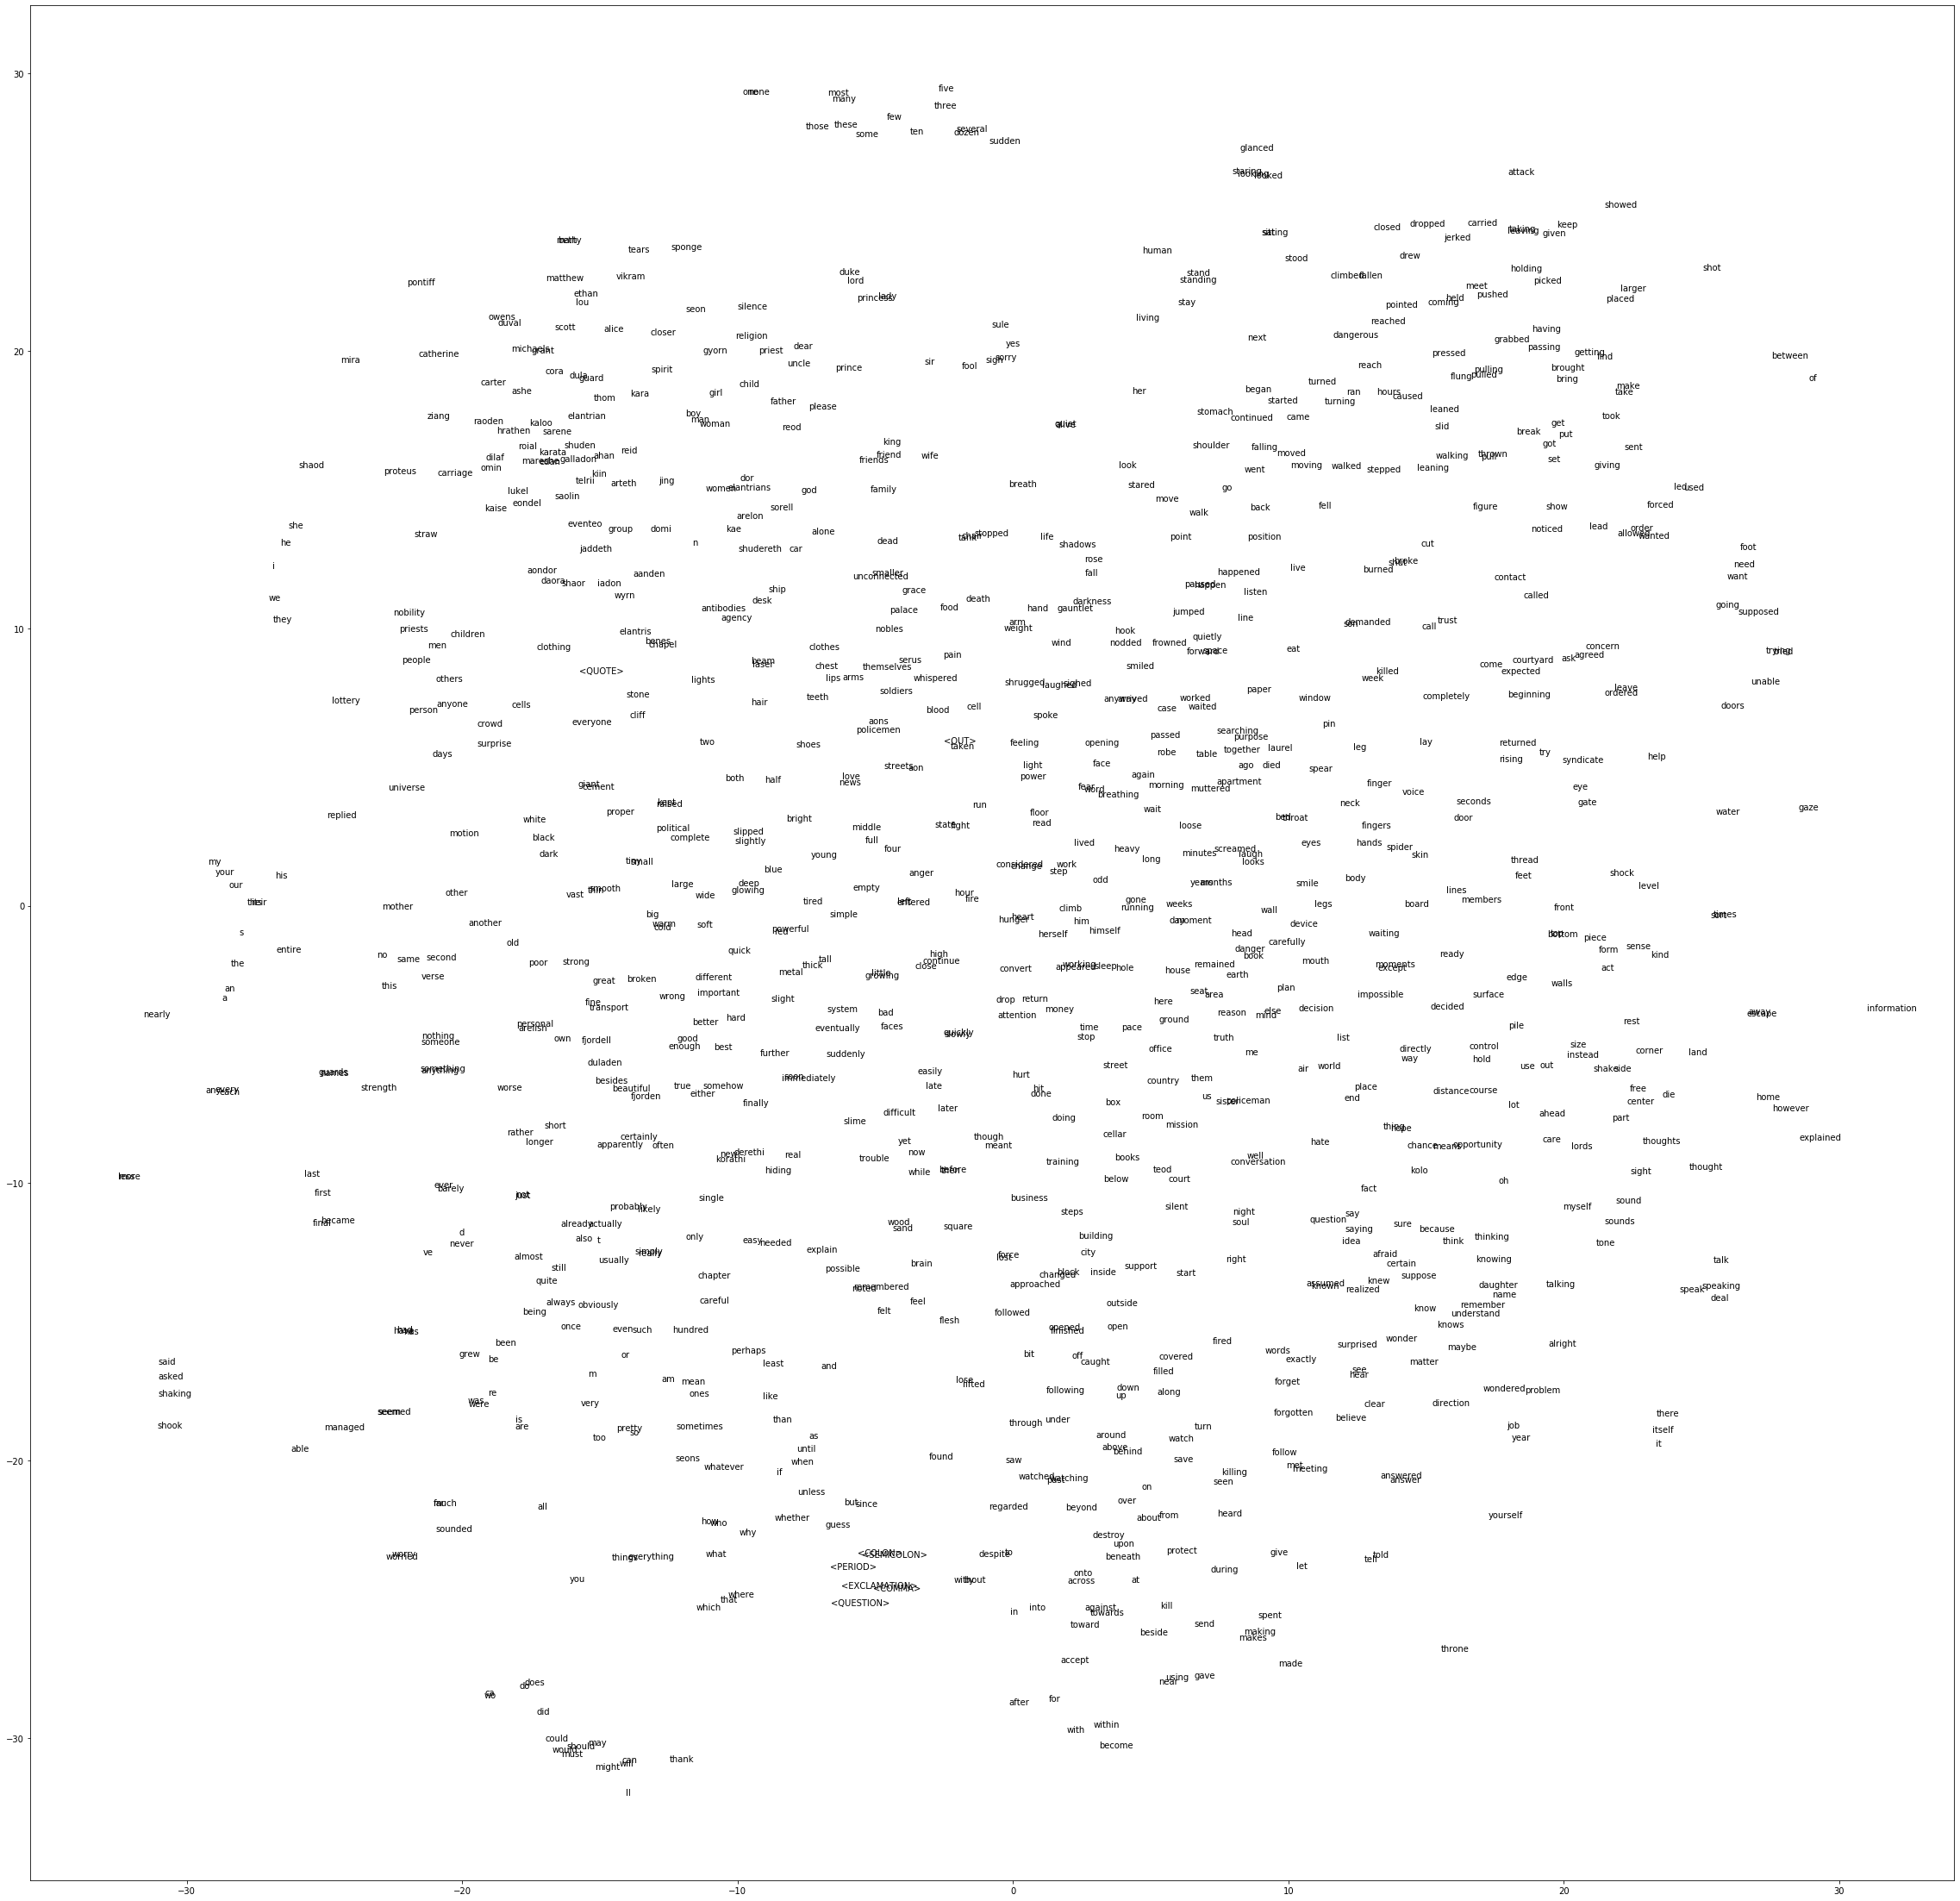

In [14]:
language_model.visualize_word_embeddings()

## Questions:

#### • Explain the main differences with the previous character based language model.
#### • Are the predicted sentences making more sense in this part? Why?

In [4]:
from torchsummary import summary
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from abc import ABC, abstractmethod
import torch
import torch.nn as nn
import sys

sys.path.append(".")
import utils


import pandas as pd
import torch.optim as optim
from torchviz import make_dot

### III - Introduction to PyTorch with classification models

This part will focus on building Deep Learning architectures for text classification using the PyTorch framework.

To do so, we will use the IMDB dataset that has 50K movie reviews for natural language processing or Text analytics. This is a dataset for binary sentiment classification.

The goal is to classify the positive and negative comments.

In [6]:
df = pd.read_csv(
    "data/movie_reviews.csv", sep=";", nrows=1e6
)

The following class, **SentimentClassifier**, is an abstract class which you have to inherit from in the next $2$ subparts.

This class forces you to implement the **forward** method that represents the neural net forward pass. Implementing this method is analogous to building a network with the Keras functional API

The constructor handles transforming most common words to indices, padding and truncating. After the constructor is done X is a LongTensor of shape $\text{(nb_reviews, max_seq_length)}$. The elements along the $\text{max_seq_length}$ axis are the word indices of a sequence

In [7]:
class SentimentClassifier(ABC, nn.Module):
    def __init__(
        self,
        dataset,
        max_vocabulary_size=20000,
        max_seq_length=100,
        truncating="post",
        padding="post",
        embedding_dim=10,
        learning_rate=0.01,
        p_val=0.2,
    ):
        super(SentimentClassifier, self).__init__()
        self.X = dataset["message"]
        self.Y = dataset["label"]
        self.X_tr = None
        self.X_val = None
        self.Y_tr = None
        self.Y_val = None
        self._construct_dataset(
            max_vocabulary_size, max_seq_length, truncating, padding, p_val
        )
        self.optimizer = None
        self.learning_rate = learning_rate
        self.criterion = nn.BCELoss(reduction="mean")
        self.total_loss = None
        self.total_acc = None
        self.total_loss_nb_samples = None

    def _construct_dataset(
        self, max_vocabulary_size, max_seq_length, truncating, padding, p_val
    ):
        self.Y = torch.FloatTensor(self.Y).unsqueeze(1)
        tokenizer = Tokenizer(num_words=max_vocabulary_size, char_level=False)
        tokenizer.fit_on_texts(self.X)
        self.X = tokenizer.texts_to_sequences(self.X)
        self.X = pad_sequences(
            self.X,
            maxlen=max_seq_length,
            value=0,
            truncating=truncating,
            padding=padding,
        )
        self.X = torch.LongTensor(self.X)
        size_val = int(p_val * self.X.shape[0])
        idxs = np.arange(self.X.shape[0])
        np.random.shuffle(idxs)
        idxs_tr = idxs[:-size_val]
        idxs_val = idxs[-size_val:]
        self.X_tr = self.X[idxs_tr]
        self.X_val = self.X[idxs_val]
        self.Y_tr = self.Y[idxs_tr]
        self.Y_val = self.Y[idxs_val]

    def _train_on_batch(self, input, target, return_metrics=True):
        self.optimizer.zero_grad()
        prediction = self.forward(input)
        loss_on_batch = self.criterion(prediction, target)
        loss_on_batch.backward()
        self.optimizer.step()
        prediction = (prediction > 0.5).type(torch.FloatTensor)
        mean_acc = torch.eq(prediction, target).type(torch.FloatTensor).mean()
        if return_metrics:
            return loss_on_batch, mean_acc

    def train(self, nb_epoch=10, batch_size=64):
        if self.optimizer is None:
            self.optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)

        arr = np.arange(self.X_tr.size()[0])
        np.random.shuffle(arr)

        nb_batch = int(self.X_tr.size()[0] / batch_size)
        verbose_every = 5 if nb_batch >= 5 else 1

        for epoch in range(nb_epoch):
            self._reset_monitor_train_epoch()
            if epoch > 0:
                print()
            for batch_idx in range(nb_batch):
                idxs = arr[batch_idx * batch_size : (batch_idx + 1) * batch_size]
                X_batch_tr = self.X_tr[idxs]
                Y_batch_tr = self.Y_tr[idxs]

                mean_batch_loss_tr, mean_acc_tr = self._train_on_batch(
                    X_batch_tr, Y_batch_tr
                )
                self._monitor_train_epoch(
                    mean_batch_loss_tr, X_batch_tr.shape[0], mean_acc_tr
                )

                if (batch_idx + 1) % verbose_every == 0:
                    self._display_training(
                        epoch, nb_epoch, batch_idx, nb_batch, epoch_ended=False
                    )

            self._monitor_validation()
            self._display_training(
                epoch, nb_epoch, batch_idx, nb_batch, epoch_ended=True
            )

    def _monitor_train_epoch(self, mean_batch_loss, batch_size, mean_acc):
        self.total_loss += mean_batch_loss * batch_size
        self.total_acc += mean_acc * batch_size
        self.total_loss_nb_samples += batch_size

    def _reset_monitor_train_epoch(self):
        self.total_loss = 0
        self.total_loss_nb_samples = 0
        self.total_acc = 0

    def _monitor_validation(self):
        prediction_val = self(self.X_val)
        self.last_loss_val = self.criterion(prediction_val, self.Y_val)
        prediction_val = (prediction_val > 0.5).type(torch.FloatTensor)
        self.last_acc_val = (
            torch.eq(prediction_val, self.Y_val).type(torch.FloatTensor).mean()
        )

    def _display_training(
        self, epoch, nb_epoch, idx_batch, nb_batch, epoch_ended=False
    ):
        msg = "Epoch {}/{} {} {} {}".format(
            epoch + 1,
            nb_epoch,
            utils.arrow(idx_batch + 1, nb_batch),
            " mean loss: %.5f" % (self.total_loss.item() / self.total_loss_nb_samples),
            " mean acc : %.2f" % (self.total_acc / self.total_loss_nb_samples),
        )
        if epoch_ended:
            msg += " val loss: {:.5f} val acc: {:.2f}".format(
                self.last_loss_val, self.last_acc_val
            )
        print(msg, end="\r")

    @abstractmethod
    def forward(self, input):
        pass

### III - a) Simple classification model

The following computes a very simple model:
<img src="../images/supervised_text_classification.png" style="width: 600px;" />
Use the layers that can be found under torch.nn: https://pytorch.org/docs/stable/nn.html
- torch.nn.Embedding: build an embedding layer mapping each word to a vector representation
- torch.nn.Linear: end with a matrix product to set output at the right dimension (here $1$)

In [8]:
"""
    Finish to implement the constructor.
    - Instantiate self.embedding, that should be able to encode 
    a vocabulary of self.max_vocabulary_size words vector at last 
    timestep to be used for classification
    - The output of the embedding layer should be 
    (batch_size, max_seq_length, embedding_dim), compute the mean of the 
    tensor over the max_seq_length to produce a sentence context vector 
    to be used for classification
    - Instantiate self.linear, a product matrix layer to be used over the 
    context vector to set the final output at the right dimension 
    hints:
        - To make the output between 0 and 1, use the torch.sigmoid method
"""
class AverageSentimentClassifier(SentimentClassifier):
    def __init__(
        self,
        dataset,
        max_vocabulary_size=20000,
        max_seq_length=200,
        truncating="post",
        padding="post",
        embedding_dim=10,
        learning_rate=0.01,
        p_val=0.2,
    ):

        super(AverageSentimentClassifier, self).__init__(
            dataset,
            max_vocabulary_size=max_vocabulary_size,
            max_seq_length=max_seq_length,
            truncating=truncating,
            padding=padding,
            embedding_dim=embedding_dim,
            learning_rate=learning_rate,
            p_val=p_val,
        )

        self.embedding = nn.Embedding(int(self.X.max().item()) + 1, embedding_dim)
        self.linear = nn.Linear(embedding_dim, 1)

    def forward(self, input):
        # cast float to int when random float numbers are via torchsummary
        input = (
            input.type(torch.LongTensor)
            if not isinstance(input, torch.LongTensor)
            else input
        )

        x = self.embedding(input)
        x = x.mean(dim=1)
        x = self.linear(x)
        x = torch.sigmoid(x)
        return x

In [21]:
avg_sentiment_classifier = AverageSentimentClassifier(df)

In [22]:
try:
    summary(avg_sentiment_classifier, (avg_sentiment_classifier.X_tr.shape[1],))
except:
    avg_sentiment_classifier = AverageSentimentClassifier(df)
    print(avg_sentiment_classifier)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1              [-1, 200, 10]         200,000
            Linear-2                    [-1, 1]              11
Total params: 200,011
Trainable params: 200,011
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.76
Estimated Total Size (MB): 0.78
----------------------------------------------------------------


In [23]:
avg_sentiment_classifier.train(nb_epoch=3, batch_size=64)

Epoch 1/3 ==================================================>  mean loss: 0.42546  mean acc : 0.81 val loss: 0.31727 val acc: 0.87
Epoch 2/3 ==================================================>  mean loss: 0.24658  mean acc : 0.91 val loss: 0.29570 val acc: 0.88


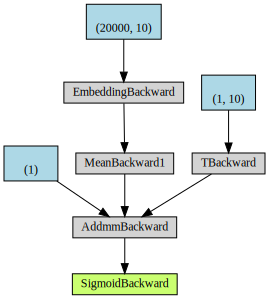

In [24]:
y = avg_sentiment_classifier(avg_sentiment_classifier.X_tr[:1])
make_dot(y)

### III - b) Recurrent classification model

Now we are going to enrich the previous model with recurrent LSTM layers:
<img src="../images/rnn.png" style="width: 600px;" />
Use the layers that can be found under torch.nn: https://pytorch.org/docs/stable/nn.html
- torch.nn.Embedding: build an embedding layer mapping each word to a vector representation
- torch.nn.LSTM: process batch of sequences of embedded words to batch of final hidden vectors
- torch.nn.Linear: end with a matrix product to set output at the right dimension (here $1$)

**NB: note that pytorch RNNs such as LSTM or GRU expect an input tensor of shape $\text{(nb_timesteps, batch_size, hidden_dim)}$. After embedding in the forward pass, if the batch_size axis is in 1st position you have to switch it to the middle using the torch.Tensor.permute method**

In [25]:
"""
    Finish to implement the constructor.
    - Instantiate self.embedding, that should be able to encode 
    a vocabulary of self.max_vocabulary_size words
    - Instantiate self.lstm, should go through all embedded words 
    in a sentence and produce a final hidden vector at last timestep 
    to be used for classification
    - Instantiate self.linear, a product matrix layer to be used over 
    the LSTM output to set the final output at the right dimension 
    note:
        - in forward method, input is of shape (batch_size, max_seq_length)
        but torch.nn.LSTM layer expects an input of shape (max_seq_length, batch_size, embedding_dim).
        Be careful about the position of the batch_size axis
    hints:
        - To make the output between 0 and 1, use the torch.sigmoid method
"""
class LstmSentimentClassifier(SentimentClassifier):
    def __init__(
        self,
        dataset,
        max_vocabulary_size=20000,
        max_seq_length=100,
        truncating="post",
        padding="post",
        embedding_dim=10,
        learning_rate=0.01,
        p_val=0.2,
        hidden_dim=32,
    ):

        super(LstmSentimentClassifier, self).__init__(
            dataset,
            max_vocabulary_size=max_vocabulary_size,
            max_seq_length=max_seq_length,
            truncating=truncating,
            padding=padding,
            embedding_dim=embedding_dim,
            learning_rate=learning_rate,
            p_val=p_val,
        )

        self.embedding = nn.Embedding(int(self.X.max().item()) + 1, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, input):
        # cast float to int when random float numbers are via torchsummary
        input = (
            input.type(torch.LongTensor)
            if not isinstance(input, torch.LongTensor)
            else input
        )

        x = self.embedding(input)
        x = x.permute(1, 0, 2)
        # h0 and c0 default to 0 when not provided
        h_ts, (h_T, c_T) = self.lstm(x)
        x = self.linear(h_T)
        x = torch.sigmoid(x)
        return x

In [26]:
lstm_sentiment_classifier = LstmSentimentClassifier(df)

In [27]:
# just print model here, torchsummary.summary does not do well with lstm layer
print(lstm_sentiment_classifier)

LstmSentimentClassifier(
  (criterion): BCELoss()
  (embedding): Embedding(20000, 10)
  (lstm): LSTM(10, 32)
  (linear): Linear(in_features=32, out_features=1, bias=True)
)


In [29]:
lstm_sentiment_classifier.train(nb_epoch=3, batch_size=32)

Epoch 1/3 ==================================================>  mean loss: 0.26396  mean acc : 0.89 val loss: 0.36426 val acc: 0.85
Epoch 2/3 ==================================================>  mean loss: 0.19383  mean acc : 0.93 val loss: 0.41745 val acc: 0.84
